In [54]:
# load packages
import pyproj,os,rioxarray
import xesmf as xe
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import cartopy.crs as crs
import matplotlib
from cartopy.feature import NaturalEarthFeature 
import cartopy.feature as cfeature
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 Constants,extract_vars)
from matplotlib import pyplot as plt
# Define global setting
xr.set_options(keep_attrs=True)

In [2]:
# Build curvilinear grids for netcdfs
def build_wrf_gird(WRF_d,geo_file):
    """
    Function: build x,y curvilinear grids from WRF input dataset and geo_em
    Input: path for WRF dataset, path for geo_em file
    Output: WRF netcdf with curvilinear grid in lat/lon, coordinate system for WRF24
    """
    # Open geo_em file, get HGT var, cart_proj and lats and lons
    geo=Dataset(geo_file)
    HGT = getvar(geo,"HGT_M",timeidx=ALL_TIMES)
    WRF_cart_proj = get_cartopy(HGT)
    WRF_lats, WRF_lons = latlon_coords(HGT)
    # Create WRF Projection
    wrf_globe = crs.Globe(ellipse=None,
                          semimajor_axis=Constants.WRF_EARTH_RADIUS,
                          semiminor_axis=Constants.WRF_EARTH_RADIUS)
    # Define a latitude/longitude coordinate system
    wrf_xform_crs = crs.Geodetic(globe=wrf_globe)
    # Open dataset
    if '_mon_' in WRF_d: 
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'month':12})
    elif '_sea_' in WRF_d:
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'season':4})
    
    # Insert lat and lon for re-gridding
    WRF_latlon=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_lats.values),'lon':(('south_north','west_east'),WRF_lons.values)})
    # Drop coordinate XTIME
    WRF_latlon=WRF_latlon.drop_vars(['XTIME'])
    return WRF_latlon,WRF_cart_proj, wrf_xform_crs

In [3]:
# Interpolate to WRF24 grids
def to_WRF_grid(WRF,WRF_proj,WRF_crs,obs_d=None):
    """
    Function: Interpolate input dataset to WRF24 grid and perform remapping 
    Input: WRF xarray dataset with lat and lon,WRF porjection, WRF coordinate system, 
           Observation dataset
           remap from polar to WRF24 for i.ie. Rutgers Northern Hemisphere 24 km Weekly Snow Cover Extent
           or from WGS1984 to WRF24 for i.e. ERA5 Land
    Output: netcdf with curvilinear grid in EPSG 4326
    """
    # Grab ending year of WRF dataset
    year_end=int(WRF.attrs['end_date'][0:4])+1
    # For WRF output
    if obs_d==None:
        # Generate lat long based on WRF Projection
        xform_pts = WRF_proj.transform_points(WRF_crs,to_np(WRF.lon),to_np(WRF.lat))
        WRF_x = xform_pts[...,0]
        WRF_y = xform_pts[...,1]
        # insert lat and lon grids into dataset         
        WRF_output=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_y),'lon':(('south_north','west_east'),WRF_x)})
        return WRF_output
    else:
    # Open dataset
    # For rutger dataset
        if 'rutgers' in obs_d:
            obs_raw=xr.open_dataset(obs_d,chunks={'time':100})
    # For ERA5-Land dataset
        elif 'era5l' in obs_d:
            obs_raw=xr.open_mfdataset(obs_d)
            # Rechunk dataset
            obs_raw=obs_raw.chunk({'time':200,'latitude':200,'longitude':500})
        # Generate normal for dataset
        if 'month' in WRF.coords:
            obs_norm=obs_raw.isel(time=(obs_raw.time.dt.year<year_end)).groupby('time.month').mean('time')
        if 'season' in WRF.coords:
            obs_norm=obs_raw.isel(time=(obs_raw.time.dt.year<year_end)).groupby('time.season').mean('time')
        # Rename lat/lon
        obs_output=obs_norm.rename({'latitude':'lat','longitude':'lon'})
        # Mask missing value for Rutger dataset
        if 'rutgers' in obs_d:
            # Extract lat/lon as 2d numpy arrays
            obs_lat=obs_output.lat.values
            obs_lon=obs_output.lon.values.T
            # Replace missing values with nan
            new_lat=np.where(obs_lat>90,np.nan,obs_lat)
            new_lon=np.where(obs_lon>180,np.nan,obs_lon)
            obs_output=obs_output.assign_coords({'lat':(('x','y'),new_lat),'lon':(('x','y'),new_lon)})
        # Regrid to WRF24
        Regridder=xe.Regridder(obs_output,WRF,'patch')
        print('Regridding start')
        obs_output_re=Regridder(obs_output)
        # Transform to WRF Projection
        xform_pts = WRF_proj.transform_points(WRF_crs,to_np(obs_output_re.lon.values),to_np(obs_output_re.lat.values))
        obs_wrf_x = xform_pts[...,0]
        obs_wrf_y = xform_pts[...,1]
        obs_output_re=obs_output_re.assign_coords({'lat':(('south_north','west_east'),obs_wrf_y),
                                                        'lon':(('south_north','west_east',),obs_wrf_x)})
        return obs_output_re

In [4]:
# Compute biases and generate plots
def find_outlier(obs_d,conus_d,new_d,newloc_d,geo_file,v_min,v_max,obs_src=None,par=None):
    """
    Function: Compute biases and generate plot based on parameter chosen
    Inputs: Observational, WRF-Conus, New, newloc xarray datasets regridded to WRF24
            Observational dataset source (i.e. ERA5L/Rutger)
            parameter to compare (i.e. snow cover)
            Land mask as 2d numpy array
    Output: Bias plots
    """
    # Define seasons
    seasons=['DJF','MAM','JJA','SON'] 
    # Choose variable from xarray datasets
    if par=='SNOWC':
        if obs_src=='ERA5L':
            obs_raw=obs_d.snowc/100
            obs_raw=obs_raw
        elif obs_src=='Rutger':
            obs_raw=obs_d.snow_cover_extent
        conus_raw=conus_d.SNOWC
        new_raw=new_d.SNOWC
        newloc_raw=newloc_d.SNOWC
    # Store WRF as dictionary
    WRF_raw={'CONUS':conus_raw,'NEW':new_raw,'NEWLOC':newloc_raw}
    # Compute biases and store in new dictionary
    WRF_biases={}
    # Extract land mask (0: water and 1: for land)
    LM = xr.open_dataset(geo_file)
    LM = LM.LANDMASK.values[0]
    # get shape for empty array
    N,M=LM.shape
    # Creat empty for storing lower/upper quantile and  points with data
#     WRF_biases_q1=np.empty([4])
#     WRF_biases_q2=np.empty([4])
    WRF_with_data=np.empty([4,3])
    WRF_all_pts=np.empty([3,4,N,M])
    for j,physics in enumerate(WRF_raw.keys()):
        WRF_biases[physics]=WRF_raw[physics]-obs_raw
        # Find values for seasonal quantiles
        print('Calculating for',physics,'....\n')
        WRF_all_pts[j]=WRF_biases[physics].values
        for i,s in enumerate(seasons):
            WRF_all_pts[j,i][LM==0]=np.nan
            WRF_biases[physics][i]= WRF_all_pts[j,i]
            # Find the total number of points with data
            WRF_with_data[i,j]=np.sum(~(np.isnan(WRF_all_pts[j,i])))
#     for i,s in enumerate(seasons):    
#         # Compute quantile
#         WRF_biases_q1[i]=np.nanquantile(WRF_all_pts[:,i],q1)
#         print("{:<76}".format(s+' '+q1+' quantile'),"%.2f"%(WRF_biases_q1[i]))
#         WRF_biases_q2[i]=np.nanquantile(WRF_all_pts[:,i],q2)
#         print("{:<76}".format(s+' '+q2+' quantile'),"%.2f"%(WRF_biases_q2[i]))
    # Find % values outside of vmin and vmax for each season and models
#     for j,physics in enumerate(WRF_biases.keys()):
#         for i,season in enumerate(seasons):
            # Compute % of outliers for lower and upper bound
            WRF_outlier_L=np.nansum(WRF_all_pts[j,i]<v_min[i])/WRF_with_data[i,j]*100
            WRF_outlier_U=np.nansum(WRF_all_pts[j,i]>v_max[i])/WRF_with_data[i,j]*100
        # Print results
            print("{:<80}".format('% points outside range (lower,upper,total) for var '+par+':'+ \
                ', season '+s+', model '+physics+ \
                ' ='),"%.2f"%(WRF_outlier_L),"%.2f"%(WRF_outlier_U),"%.2f"%(WRF_outlier_L+WRF_outlier_U),'\n')
    return WRF_biases,WRF_all_pts

In [69]:
def build_plots(WRF_biases,WRF_proj,WRF_all_pts,v_min,v_max,obs=None,par=None,par_s=None):
    # Set variables for plots
    seasons=['DJF','MAM','JJA','SON'] 
    season_name=['Winter','Spring','Summer','Fall']
    # Set natural feature
    states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    land_edge_color=[0.55, 0.55, 0.55]
    # Plotting
    fig = plt.figure(figsize=(28,42))
    # Add season titles
    for i,s in enumerate(seasons):
        # Add season name
        fig.text(-0.04,0.14+(3-i)*0.24,season_name[i], ha='center',va='center',rotation=90,fontsize=48)
        c_norm = matplotlib.colors.TwoSlopeNorm(vmin=v_min[i],vcenter=0,vmax=v_max[i]) 
        for j,physics in enumerate(WRF_biases.keys()):
            # choose plot location and projection
            ax = fig.add_subplot(4,3,1+j+3*i,projection=WRF_proj)
            # Add Natural features
            ax.add_feature(cfeature.LAND,linewidth=1,edgecolor=land_edge_color,facecolor="none",zorder=3) 
            ax.add_feature(states,linewidth=1,edgecolor=land_edge_color,facecolor="none",zorder=3)   
            ax.add_feature(cfeature.LAKES,linewidth=1,edgecolor=land_edge_color,facecolor="none",zorder=3)
            # generate plots
            S=WRF_biases[physics].sel(season=s).plot.pcolormesh(x='lon',y='lat',ax=ax,       # x, y axes
                                                                add_colorbar=False,          # remove colorbar
                                                                cmap='bwr',                  # colors
                                                                norm=c_norm)                 # 
                                                                
            # Remove title
            ax.set_title('')
            # Calculate and show mean (mean over space) seasonal bias
            fig.text(0.03+0.335*j,0.783-i*0.24,"%.2f"%round(np.nanmean(np.abs(WRF_all_pts[j,i])),2), \
                ha='center',va='center',fontsize=48)   
            print(physics,s,'done')
        # Add colorbars
        cbar_ax = fig.add_axes([0.27,0.745-i*0.24,0.465,0.013])     
        cbar = plt.colorbar(S,cax=cbar_ax,orientation="horizontal",
                            extend='both',) 
        tick_locator = matplotlib.ticker.MaxNLocator(nbins=5,
                                                    min_n_ticks=6)
        cbar.locator = tick_locator
        cbar.update_ticks()        
        cbar.ax.tick_params(labelsize=40)
    # Set figure layout and add x and y labels and titles, etc 
    fig.tight_layout(pad=0.0,w_pad=2.0,h_pad=0)     
    # Add overall plot title
    fig.text(0.5,1.02,par+' Average Seasonal Bias Relative to '+obs,ha='center',va='center',fontsize=48)
        
    # Add plot titles and sub-titles
    vx=[0.17,0.50,0.84]
    # title y location
    vy_t= 0.975
    # suptitle y location
    vy_supt = -0.01     
    for i, physics in enumerate(WRF_biases.keys()):
        fig.text(vx[i],vy_t,r'$\overline{({%s}_{%s}-{%s}_{Ob})}\,/\,\overline{{%s}_{Ob}}$' %(par_s,physics,par_s,par_s),
                 ha='center',va='center',fontsize=35)
        fig.text(vx[i],vy_supt,physics+' '+par_s+' Rel. Bias',ha='center',va='center',fontsize=48)

In [6]:
WRF_conus='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/conus43-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
WRF_new='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/new43-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
WRF_newloc='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/new43loc-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
Polar='/project/a/aerler/Data/Rutgers/rutgers_monthly/original/rutgers_monthly.nc'
geo='/scratch/p/peltier/mahdinia/wrf/MPIESM12HR_HS_na24_conus43-flk_1979/geo_em.d01.nc'
era5='/project/a/aerler/Data/ERA5/era5l_monthly/original/*.nc'

In [7]:
conus=build_wrf_gird(WRF_conus,geo)
conus_re=to_WRF_grid(conus[0],conus[1],conus[2])
new=build_wrf_gird(WRF_new,geo)
new_re=to_WRF_grid(new[0],new[1],new[2])
newloc=build_wrf_gird(WRF_newloc,geo)
newloc_re=to_WRF_grid(newloc[0],newloc[1],newloc[2])

In [8]:
polar_re=to_WRF_grid(conus[0],conus[1],conus[2],obs_d=Polar)

/home/p/peltier/edmundn/miniconda3/envs/ccia_wrf/lib/python3.11/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


Regridding start


In [9]:
era5l_re=to_WRF_grid(conus[0],conus[1],conus[2],obs_d=era5)

Regridding start


In [70]:
vmin=[-0.5,-0.8,-0.9,-0.4]
vmax=[0.3,0.3,0.3,0.2]

In [10]:
snow=find_outlier(era5l_re,conus_re,new_re,newloc_re,geo,vmin,vmax,obs_src='ERA5L',par='SNOWC',par_s='SC')

Calculating for CONUS ....

% points outside range (lower,upper,total) for var SNOWC:, season DJF, model CONUS = 0.11 1.27 1.37 

% points outside range (lower,upper,total) for var SNOWC:, season MAM, model CONUS = 0.02 0.28 0.30 

% points outside range (lower,upper,total) for var SNOWC:, season JJA, model CONUS = 0.00 8.35 8.35 

% points outside range (lower,upper,total) for var SNOWC:, season SON, model CONUS = 0.14 0.33 0.47 

Calculating for NEW ....

% points outside range (lower,upper,total) for var SNOWC:, season DJF, model NEW = 0.76 3.90 4.66 

% points outside range (lower,upper,total) for var SNOWC:, season MAM, model NEW = 0.16 2.62 2.79 

% points outside range (lower,upper,total) for var SNOWC:, season JJA, model NEW = 0.07 6.76 6.83 

% points outside range (lower,upper,total) for var SNOWC:, season SON, model NEW = 0.96 9.01 9.97 

Calculating for NEWLOC ....

% points outside range (lower,upper,total) for var SNOWC:, season DJF, model NEWLOC = 1.04 2.18 3.21 

% poin

CONUS DJF done
NEW DJF done
NEWLOC DJF done
CONUS MAM done
NEW MAM done
NEWLOC MAM done
CONUS JJA done
NEW JJA done
NEWLOC JJA done
CONUS SON done
NEW SON done
NEWLOC SON done


/tmp/ipykernel_28983/1588691515.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.0,w_pad=2.0,h_pad=0)


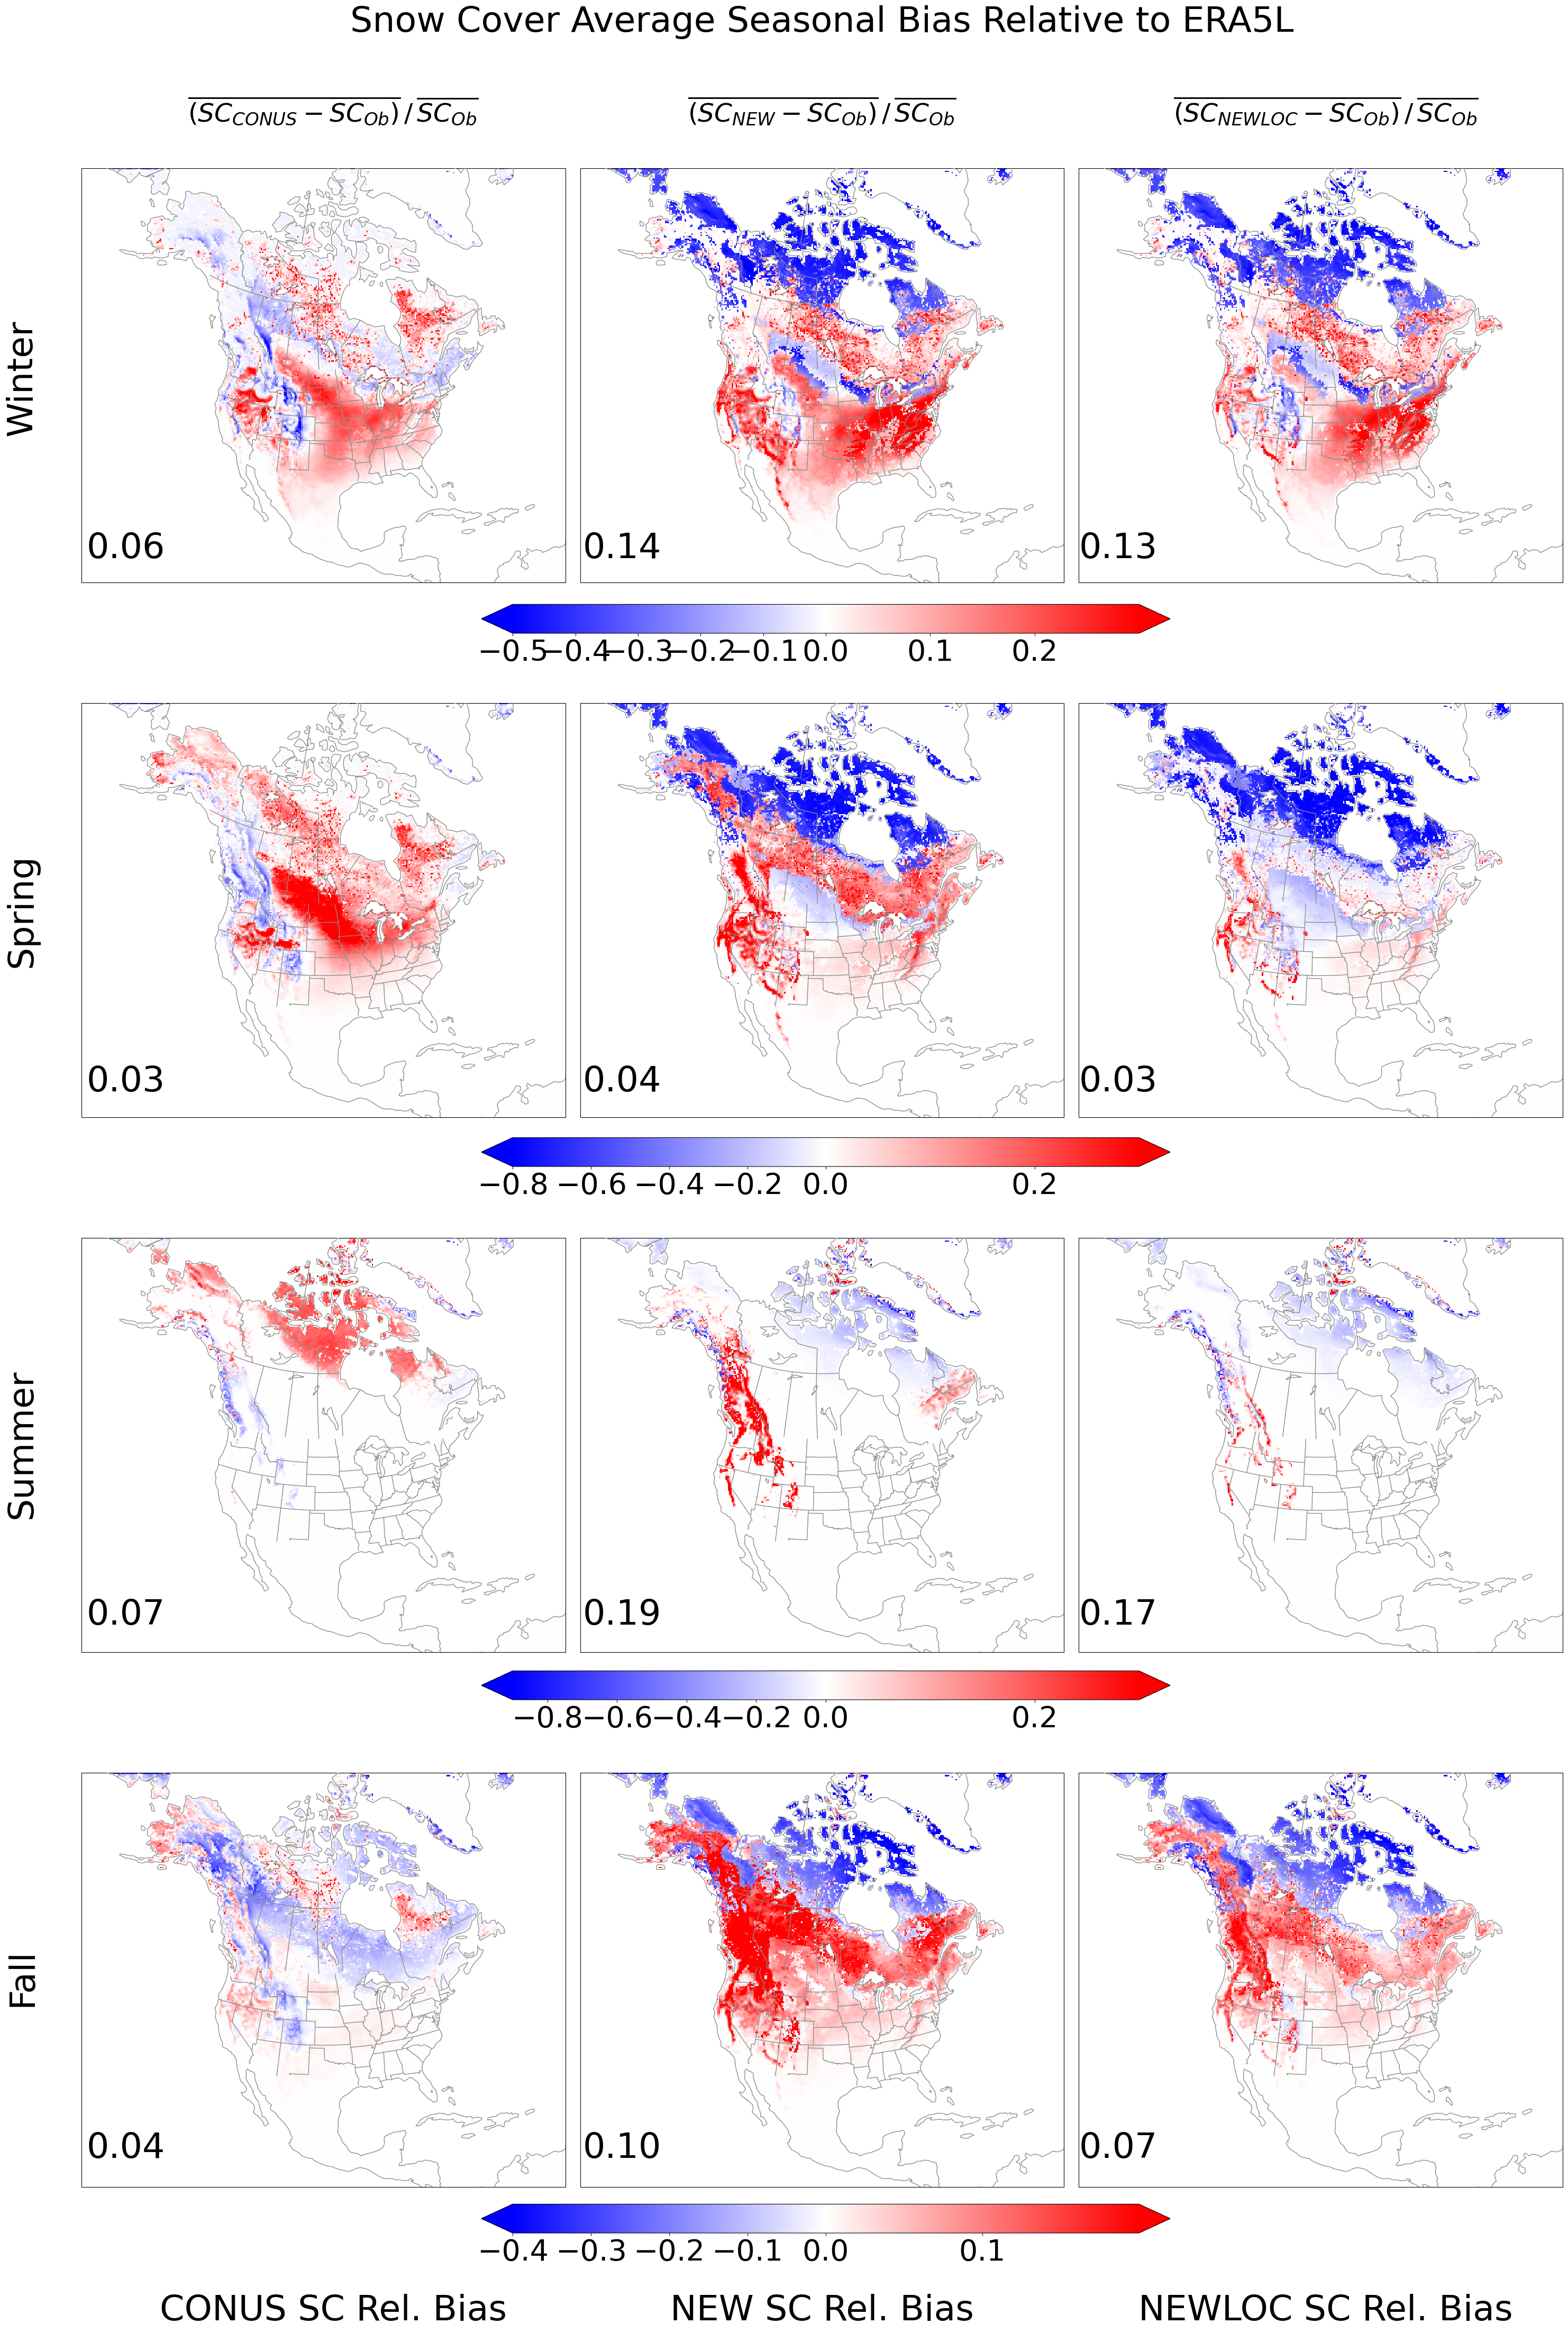

In [71]:
build_plots(snow[0],conus[1],snow[1],vmin,vmax,obs='ERA5L',par="Snow Cover",par_s='SC')